In [1]:
import import_parent

In [2]:
import tree_sim
tree_sim.EXPIRATION_TIME = 1000
tree_sim.MEMORIES_PER_END_NODE=10

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import plot_sim_results

In [5]:
import ipywidgets

In [6]:
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
%matplotlib widget
matplotlib.rcParams['toolbar'] = 'None'

In [7]:
sim = tree_sim.TreeSim(p=1e-2, k=4, n=3, t=np.inf, b=1)

interactive(children=(Play(value=0, description='frame', interval=30, max=1000000), FloatLogSlider(value=0.01,…

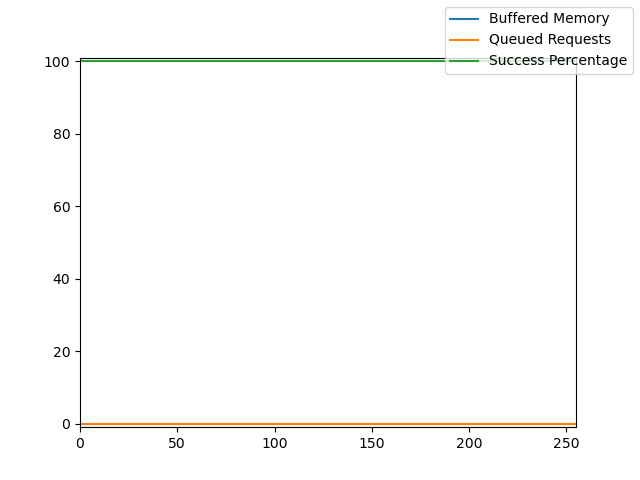

In [8]:
fig = plt.Figure()
fig.canvas.toolbar_visible = False
fig.canvas.header_visible = False
fig.canvas_footer_visible = False

datalength = 256
success_averaging_bins=16
memory_record = [0] * datalength
request_queue = [0] * datalength
success_stats = [100] * datalength
success_smooth = [100] * datalength
last_success_data = [0,0]

x_axis = list(range(datalength))
last_frame = [0]

fig, ax = plt.subplots()
memline, = ax.plot(x_axis, memory_record, label='Buffered Memory')
reqline, = ax.plot(x_axis, request_queue, label='Queued Requests')
success, = ax.plot(x_axis, success_stats, label='Success Percentage')
ax.set(xlim=(x_axis[0], x_axis[-1]), ylim=(-1,101))

fig.legend()

def animate(frame, p):
    if frame != last_frame[0]:
        last_frame[0] = frame
    else:
        return
    sim.p = p
    sim.time_cycle()
    d_sat = sim.requests_satisfied - last_success_data[0]
    d_exp = sim.requests_expired - last_success_data[1]
    last_success_data[0] = sim.requests_satisfied
    last_success_data[1] = sim.requests_expired
    success_rate = success_stats[-1]
    if d_sat + d_exp > 0:
        success_rate = d_sat * 100 / (d_sat + d_exp)
    new_data = sim.entanglements_made - sim.entanglements_used - sim.entanglements_expired
    memory_record.pop(0)
    memory_record.append(new_data)
    request_queue.pop(0)
    request_queue.append(len(sim.request_queue))
    success_stats.pop(0)
    success_stats.append(success_rate)
    success_smooth.pop(0)
    success_smooth.append(np.mean(success_stats[-success_averaging_bins:-1]))
    
    x_axis.pop(0)
    x_axis.append(x_axis[-1]+1)

    memline.set_data(x_axis, memory_record)
    reqline.set_data(x_axis, request_queue)
    success.set_data(x_axis, success_smooth)
    ax.set(xlim=(x_axis[0], x_axis[-1]), ylim=(-1,101))
    
    

play = ipywidgets.interactive(animate, frame=ipywidgets.Play(0, 0, 1e6, 1, interval=30), p=ipywidgets.FloatLogSlider(1e-2, base=10, min=-3, max=-1, step=0.1))
play